# Cleanup on Row 7

1. Clean the File
2. Handle Corrupt Rows
3. Explore Data Set Bias

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

### Helper Display Functions

In [3]:
def display_df(df, nrows=10, ncols=None):
    with pd.option_context('display.max_rows', nrows, 'display.max_columns', ncols):
        display (df)
def print_row(df, row):
    for ctr,i in enumerate(df.iloc[row]):
        print (str(df.columns[ctr])+": "+str(i))

### Helper Statistical Functions

In [4]:
#gets ratio of NaNs for each column
def stats_NaN(df):
    df_stats = pd.DataFrame(index=[df.columns], columns=["NaN Ratio"])
    for col in df.columns:
        df_stats["NaN Ratio"][col] = df[col].isna().sum()/len(df) #NaN ratio
    return df_stats.sort_values(by=['NaN Ratio'])

#helps see what fields may be incorrect by having more values than should be
def stats_unique(df, labels):
    df_counts = pd.DataFrame(index=labels,columns=['Unique Count'])
    for l in labels:
        df_counts['Unique Count'][l] = df[l].nunique()
    return df_counts

## Cleaning the Data

### Importing the Data

In [5]:
df_raw = pd.read_csv("../dirty_sample_small.csv")

ParserError: Error tokenizing data. C error: Expected 48 fields in line 652242, saw 49


Some rows have an extra field. We shall investigate what this is. First we will import the file in a more managable way, capable of handling these erroneous lines.

In [6]:
df_raw = pd.DataFrame([line.strip().split(',') for line in open('../dirty_sample_small.csv', 
                                                                'r', encoding="ISO-8859-1")])

In [7]:
len(df_raw)

661487

### Investigating Corrupt Lines and Discussing Duplicates (Part 1)

One notion of corrupt lines is the lines in the raw dataset that are formatted improperly. These lines have made it difficult to import the file, though we have worked around it with the above code. These corrupt lines have to do with cleaning the dataset so will be discussed here. Interestingly, we will check some statistics on these lines with regards to duplicate entires. There is another notion of corrupt lines, dealing with the incorrectness and contradictoriness of datapoints, that we will investigate later.

In [12]:
stats_NaN(df_raw)

,NaN Ratio
0,0
1,0
2,0
3,0.000270602
4,0.000498876
5,0.000757384
6,0.00102496
7,0.00126231
8,0.00155407
9,0.00181712


We see that that the extra has 98.6% field NaNs. This is enough to drop it. However we want to do our due diligence and investigate what the values that are not NaN are. Our suspicion is that it contains the empty string "". So we will query this dataset on the extra field for values that are not NaN or not the empty string. These rows with the empty string are likely corrupt.

In [8]:
df_raw[(pd.notna(df_raw[48]) & (df_raw[48] != ''))][48]

Series([], Name: 48, dtype: object)

We see that this returns nothing. Therefore everything in the extra field is either NaN or the empty string, so there is absolutely no value in keeping it and we will drop it. But first, lets see how many of these corrupt erroneous lines there are. We know that the construction of df_raw line by line as we did above is indifferent to the amount of columns in each row. Most of the time it saw 48 columns, in the later rows it saw 49 because of the extra empty string. The construction of the data set put NaNs in the earlier rows to ensure the shape of the dataset is intact (a regular rectangle). Therefore the source of the corrupt lines is the empty string, so if we count the empty strings in the extra field we will have successfully counted the amount of corrupt lines.

In [9]:
len(df_raw[((df_raw[48] == ''))][48])

9160

We see that there are 9160 of these rows.

In [10]:
display_df(df_raw[((df_raw[48] == ''))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
652241,HarvardX/CS50x/2014_T1,1818882,True,True,True,False,False,173.76.227.129,US,United States,Americas,Newton,MA,Massachusetts,02458,Northern America,Developed regions,,,42.3533,-71.1883,el,2002,m,0.0,0.6,2013-12-04 04:02:20,2013-12-04 04:02:20.199004,2014-04-01 23:30:47.988143,2194,39,680,8,,,,,,,Student,0,0,0,honor,1,2014-06-06 16:36:03,2014-09-15 17:57:23,notpassing,
652242,HarvardX/CS50x/2014_T1,1818882,True,True,True,False,False,173.76.227.129,US,United States,Americas,Newton,MA,Massachusetts,02458,Northern America,Developed regions,,,42.3533,-71.1883,el,2002,m,0.0,0.6,2013-12-04 04:02:20,2013-12-04 04:02:20.199004,2014-04-01 23:30:47.988143,2194,39,680,8,,,,,,,Student,0,0,0,honor,1,2014-06-06 16:36:03,2014-09-15 17:57:23,notpassing,
652243,HarvardX/CS50x/2014_T1,1818882,True,True,True,False,False,173.76.227.129,US,United States,Americas,Newton,MA,Massachusetts,02458,Northern America,Developed regions,,,42.3533,-71.1883,el,2002,m,0.0,0.6,2013-12-04 04:02:20,2013-12-04 04:02:20.199004,2014-04-01 23:30:47.988143,2194,39,680,8,,,,,,,Student,0,0,0,honor,1,2014-06-06 16:36:03,2014-09-15 17:57:23,notpassing,
652244,HarvardX/CS50x/2014_T1,1818882,True,True,True,False,False,173.76.227.129,US,United States,Americas,Newton,MA,Massachusetts,02458,Northern America,Developed regions,,,42.3533,-71.1883,el,2002,m,0.0,0.6,2013-12-04 04:02:20,2013-12-04 04:02:20.199004,2014-04-01 23:30:47.988143,2194,39,680,8,,,,,,,Student,0,0,0,honor,1,2014-06-06 16:36:03,2014-09-15 17:57:23,notpassing,
652245,HarvardX/CS50x/2014_T1,1818882,True,True,True,False,False,173.76.227.129,US,United States,Americas,Newton,MA,Massachusetts,02458,Northern America,Developed regions,,,42.3533,-71.1883,el,2002,m,0.0,0.6,2013-12-04 04:02:20,2013-12-04 04:02:20.199004,2014-04-01 23:30:47.988143,2194,39,680,8,,,,,,,Student,0,0,0,honor,1,2014-06-06 16:36:03,2014-09-15 17:57:23,notpassing,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661482,HarvardX/CS50x/2014_T1,1934738,True,False,,False,False,71.41.229.179,US,United States,Americas,Dallas,TX,Texas,75201,Northern America,Developed regions,,,32.7831,-96.8067,p,1972,m,0.0,0.6,2013-07-09 01:46:41,,,,,,,,,,,,,Student,,,,honor,1,2014-06-06 15:08:24,2014-09-15 16:35:38,notpassing,
661483,HarvardX/CS50x/2014_T1,1934738,True,False,,False,False,71.41.229.179,US,United States,Americas,Dallas,TX,Texas,75201,Northern America,Developed regions,,,32.7831,-96.8067,p,1972,m,0.0,0.6,2013-07-09 01:46:41,,,,,,,,,,,,,Student,,,,honor,1,2014-06-06 15:08:24,2014-09-15 16:35:38,notpassing,
661484,HarvardX/CS50x/2014_T1,1934738,True,False,,False,False,71.41.229.179,US,United States,Americas,Dallas,TX,Texas,75201,Northern America,Developed regions,,,32.7831,-96.8067,p,1972,m,0.0,0.6,2013-07-09 01:46:41,,,,,,,,,,,,,Student,,,,honor,1,2014-06-06 15:08:24,2014-09-15 16:35:38,notpassing,
661485,HarvardX/CS50x/2014_T1,1934738,True,False,,False,False,71.41.229.179,US,United States,Americas,Dallas,TX,Texas,75201,Northern America,Developed regions,,,32.7831,-96.8067,p,1972,m,0.0,0.6,2013-07-09 01:46:41,,,,,,,,,,,,,Student,,,,honor,1,2014-06-06 15:08:24,2014-09-15 16:35:38,notpassing,


Many of these "corrupt" lines contains valid data, so we will have to handle them. It does appear though that many of these 9160 corrupt lines are indeed duplicates. Lets see how many. We consider duplicates to be rows with `course_id` and `user_id` to be the same as no student should be able to register for the same course more than once. `course_id` and `user_id` are the first 2 fields in the raw dataset. 

In [11]:
len(df_raw[((df_raw[48] == ''))].drop_duplicates(subset=[0,1],
                                                 inplace=False))

710

So of the 9160 corrupt lines, at least 9160 - 710 = 8450 are duplicates. I say at least because even those 710 lines may be duplicates with the rest of the raw dataset as this analysis above only considers rows with the empty string in the extra field. So we can analyze overall the amount of duplicates in the whole raw dataset and compare.

In [12]:
len(df_raw.drop_duplicates(subset=[0,1],inplace=False))

50002

Interestingly, there are still many more duplicates. However, if we had dropped duplicates at this stage, then we would have also gotten rid of at least 8450 corrupt lines. There could be more as the 710 lines with the extra field may be duplicates with the rest of the uncorrupt dataset. Therefore we posit, that dropping duplicates would drastically change the count of corrupt lines. We shall prove this with the code below.

In [13]:
len(df_raw.drop_duplicates(subset=[0,1],inplace=False)[df_raw[48] == ''])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0

0! This means that these corrupt lines are all duplicates with respect to the rest of the dataset. As we said above, this means that all of these rows are users who have registered for a given particular class that have corresponding `course_id`-`user_id` pairs in the rest of the uncorrupt dataset, therefore all of these 9160 corrupt are duplicates. Therefore simply dropping duplicates in the whole dataset would drop all of the corrupt lines, with this definition of corrupt (the extra field) from the dataset. We shall explore another notion of corruption later.

### Fixing the Shifted Data

We observe that some of the data appears scrambled. Meaning some of the data for some columns is in the wrong columns. We elucidate below. But first, lets give our dataset acceptable column names and drop the erroneous column. From now on, we will be using the goal dataset (the future fully cleaned one) called `df_clean`.

In [47]:
df_clean = df_raw.copy()
df_clean = df_clean.rename(columns=df_raw.iloc[0])
df_clean = df_clean.drop(df_clean.index[0])
df_clean = df_clean.drop(np.nan, axis=1)

In [337]:
stats_unique(df_clean, df_clean.columns)

,Unique Count
course_id,21
user_id,49144
registered,3
viewed,3
explored,3
certified,2
completed,44101
ip,799
cc_by_ip,295
countryLabel,96


In [338]:
stats_NaN(df_clean)

,NaN Ratio
course_id,0
user_id,0
registered,0
viewed,0.000270603
explored,0.000498877
certified,0.000757386
completed,0.00102497
ip,0.00126231
cc_by_ip,0.00155408
countryLabel,0.00181712


The first perceivable error in the dataset occurs under the completed field. It often has the IP in it. Therefore, one of the early fields is the source of the problem. Perhaps one field is missing. However we are finding it difficult to determine which one. Sometimes, `viewed` is empty, sometimes `explored` is. Often we see `registered` equal to False, which also makes no sense as in order to be a row in the dataset that user needs to be registered for the course. Initially we are thinking that whenever `registered` is False, that it should really be True and that is the source of the missing field and therefore the cause of the shift. However, we cant be certain. Sometimes `registered` is indeed True. `completed` is an important field for researchers of the edX dataset, so we most definitely must repair this column, and we can likely assume that one of the previous columns, probably `certified` contains the values for that column. But which column is missing? The four fields previous `completed` are all booleans, so it is difficult to identify where the problem originates. We know for sure that if the `ip` is in the completed column we can shift the datapoints starting in `completed` over to the right one. We have decided that the source of the shift is the `registered` column. It is the least important for researchers as it is redundant and should always be True. Therefore we start the shift over from there and fill the value with True.

We target the `completed` column for values that look like IP addresses. In this case, we are looking for values that would not be the acceptable values in the `completed` column. The `completed` column should have either True, False, or perhaps None or empty string - anything that is not these is likely an IP address. **We discovered later that the empty string is a source of a shift and remedied that.** We then shift everything beginning at `registered` over as that is a reasonable assumption as to what the missing column is and we will then fill that column with Trues as everyone in the database is registered for the class. We do recognize that any of the other boolean fields could have been the source of the shift like `viewed`, `explored`, `certified`, or even `completed` (though we think this is less likely given these fields seem more important for analysis). A cursory glance at the data shows that `explored` is often empty - could this be the source of the problem? We think not, as we remember many NaN values in the `explored` column in the previous pset.

In [48]:
#gets rows that look like the IP or the empty string is in the completed field 
#and shifts them
df_shift = df_clean[~df_clean['completed'].isin(['True','False', None])]\
[df_clean.columns[2:]].shift(1, axis=1)
df_shift.registered = 'True'

In [49]:
df_clean.loc[~df_clean['completed'].isin(['True','False', None]),\
            df_clean.columns[2:]] = df_shift

In [50]:
df_clean[df_clean['user_id']=='2014-09-15 17:57:23']

,course_id,user_id,registered,viewed,explored,certified,completed,ip,cc_by_ip,countryLabel,...,nforum_pinned,roles,nprogcheck,nproblem_check,nforum_events,mode,is_active,cert_created_date,cert_modified_date,cert_status
652240,6:36:03,2014-09-15 17:57:23,notpassing,,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


This row is identified in our `fix_types` function as a shift, but it is complete garbage, so we will just drop it.

In [51]:
df_clean = df_clean.drop(652240)

We have successfully fixed the shifting in the dataset! Our function below proves it as it does not identify any shifts.

### Fixing Data Types and Handling Missingness

Now that we have fixed the shifting, it will be more efficient to fix the datatypes. They are incorrect in multiple ways. For example, things that say False are not really the boolean value for false, but rather the string. In fact everything is a string. We will correct this in a systematic way. We will try to best follow the guidelines outlined here: https://elitedatascience.com/data-cleaning. We will have 2 functions. One for handling the fields that are supposed to be strings and the other for the other types. `fix_types_strings` will be like pandas replace function and deal with finding the empty strings. The other function `fix_types` will take a dictionary of column names to datatypes and run through the columns correcting the datatypes. Columns not specified in the dictionary will be left as strings.

The dictionary for chaning the non-string types is below. Most of these type conversions are self explanatory. But some of these choices in type conversions and in conversions I dont make require explanation. I am leaving `postalCode` as a string: this is because not all postal codes are numbers, some contain letters like in Great Britain. For `latitude` and `longitude` a float is enough space to hold their values, a double is not necessary. Many of the fields require datetime format which will be handled in the `fix_types` function. Lastly, `is_active` is described as an integer 1 or 0 in the documentation (and not a boolean) so we will treat it as such. The dictionary is equipped with the default value in the case that a datapoint is missing. Our `fix_types` function will utilize this.

In [52]:
missing_int = 0
missing_float = 0
missing_bool = False
missing_datetime = datetime.min
type_dict = {
    'user_id' : (int, missing_int),
    'registered' : (bool, missing_bool),
    'viewed' : (bool, missing_bool),
    'explored' : (bool, missing_bool),
    'certified' : (bool, missing_bool),
    'completed' : (bool, missing_bool),
    'latitude' : (float, missing_float),
    'longitude' : (float, missing_float), 
    'YoB' : (int, missing_int),
    'grade' : (float, missing_float),
    'passing_grade' : (float, missing_float),
    'start_time' : ('datetime', missing_datetime),
    'first_event' : ('datetime', missing_datetime),
    'last_event' : ('datetime', missing_datetime),
    'nevents' : (int, missing_int),
    'ndays_act' : (int, missing_int),
    'nplay_video' : (int, missing_int),
    'nchapters' : (int, missing_int),
    'nforum_posts' : (int, missing_int),
    'nforum_votes' : (int, missing_int),
    'nforum_endorsed' : (int, missing_int),
    'nforum_threads' : (int, missing_int),
    'nforum_comments' : (int, missing_int),
    'nforum_pinned' : (int, missing_int),
    'nprogcheck' : (int, missing_int),
    'nproblem_check' : (int, missing_int),
    'nforum_events' : (int, missing_int),
    'is_active' : (int, missing_int),
    'cert_created_date' : ('datetime', missing_datetime),
    'cert_modified_date' : ('datetime', missing_datetime)
}

The `fix_types` function will be equipped to deal with missingness in the columns provided to the function. Following the guidelines from above, we will "flag and fill", meaning we will put in a default value like 0 and add a column indicating the a value in that field was missing. We will deal with the missingness in the string values after.

In [53]:
dt_format = "%Y-%m-%d %H:%M:%S"
dt_format_catch = "%Y-%m-%d %H:%M:%S.%f"

In [54]:
"""
Goes through columns specified in the dictionary (the keys) and casts them as the 
appropriate type (the value). The dict will only contain fields that need to be 
changed from string, as everything else should be left as a string. For fields of 
datetime format, the input variables dt_format is the format provided to strptime,
dt_format_catch is the alternative datetime format in the case dt_format caused an 
error. This function 'flags and fills', meaning it fills missing values with the 
default specified in the dictionary and adds columns to the dataframe to indicate
the missingness of fields.
"""
def fix_types(df, type_dict, dt_format, dt_format_catch):
    #the function passed to the apply on the column
    def fix_type(s, type_value, missing_value, dt_format, dt_format_catch):
        if pd.isnull(s) or s=='' or s==' ' or s=='none' or s=='null':
            return missing_value
        if type_value != 'datetime':
            try:
                return type_value(s)
            except ValueError as v: #handles junk datapoints
                #helps identify other shift
                print('potential shift: '+s) #if correct, should never print
                assert(False) #unit testing to ensure it works
                return missing_value
        elif type_value == 'datetime':
            try:
                return datetime.strptime(s, dt_format)
            except ValueError as v:
                return datetime.strptime(s, dt_format_catch)
    for key, (type_value, missing_value) in type_dict.items():
        print('Cleaning ' + str(key) + '...')
        df[key] = df[key].apply(lambda s : fix_type(s, type_value, missing_value,
                                                   dt_format, dt_format_catch))
        #check if contains missing_value and add column
        if missing_value in df[key].values:
            df['missing_'+str(key)] = df[key]==missing_value
    print('Finished!')
    return df

We have written the function to help us find more shifts. For example, we have just identified that the empty string in the `completed` field is the source of a shift. We will go back and fix that now.

In [55]:
df_clean = fix_types(df_clean, type_dict, dt_format, dt_format_catch)

Cleaning user_id...
Cleaning registered...
Cleaning viewed...
Cleaning explored...
Cleaning certified...
Cleaning completed...
Cleaning latitude...
Cleaning longitude...
Cleaning YoB...
Cleaning grade...
Cleaning passing_grade...
Cleaning start_time...
Cleaning first_event...
Cleaning last_event...
Cleaning nevents...
Cleaning ndays_act...
Cleaning nplay_video...
Cleaning nchapters...
Cleaning nforum_posts...
Cleaning nforum_votes...
Cleaning nforum_endorsed...
Cleaning nforum_threads...
Cleaning nforum_comments...
Cleaning nforum_pinned...
Cleaning nprogcheck...
Cleaning nproblem_check...
Cleaning nforum_events...
Cleaning is_active...
Cleaning cert_created_date...
Cleaning cert_modified_date...
Finished!


Now that we have dealt with missingness in the non-string types, we will handle the string types. The guidelines recommend filling in missing categoricals (in our case all of the strings) with "missing". So we shall do that.

In [56]:
df_clean = df_clean.fillna('missing')

In [57]:
#missing_list=['',' ']
#df_clean = df_clean.replace(missing_list, 'missing')

Pandas replace is incredibly slow. So we will write are own function.

In [58]:
#get columns to replace
str_cols = list(set(df_clean.columns) - set(type_dict.keys()))
str_cols = [s for s in str_cols if not s.startswith('missing')]

In [59]:
"""
Fills in missing values identified by the missing_list with the proper missing_value.
Pandas fillna handles the other missing value identifers like NaN and None.
"""
def fix_types_strings(df, cols, missing_list=['',' ','null','none','None'], 
                      missing_value='missing'):
    for col in cols:
        df[col] = df[col].map(lambda s: missing_value if s in missing_list else s)
    return df

In [60]:
df_clean = fix_types_strings(df_clean, str_cols)

We have cleaned and dealt with missingness in the fields that are numerical boolean, and datetime, and properly flagged them. Now we are finished dealing with missingness and fixing the datatypes.

### Testing

In [96]:
def is_ip(s):
    return (len(s.split('.'))==4)

In [ ]:
def check_types(df):
    

## Investigating Corrupt Lines and Discussing Duplicates (Part 2)

In the first section, we discussed rows with an extra field, which threw off the importation of the dataset, and then discussed how removing duplicates affected those fields. In this section, we investigate corruptness that involves contradictoriness in the values of the dataset. I believe this is the most salient definition of corruptness as the rows are fully fleshed out, but the analysis that may come from them could be faulty. 

Let's think about how values in a row could contradict eachother. For one, if a student has completed the course then they also must have viewed the course. Therefore if `completed` is True and `viewed` is False we can reasonably assume something is wrong, so we will flag it. Our flagging will be in a new column we create `corrupt`. We will have to make sure that missingness is accounted for - meaning if `viewed` was actually missing, it would be default filled in with False, which would be a sign of contradiction. But we should not let missingness indicate corruption, so we will need to check the missing columns to appropriately handle these cases. Another form of contradiction can occur with `completed` and the relationship between `grade` and `passing_grade`. If `grade` < `passing_grade` and `completed` is True, than that would be a contradiction as the list of variables describes that "grade >=	passing_grade" for `completed` to be True. We will not examine potential corrupt relationships with `explored` as a student can likely pass without looking through half the course's chapters. Another potential source for corruption involves incorrect locations. For example, if someone was from New York state and the `countryLabel` is United Kingdom. We will not check for this type of corruption as it is out of the scope of this data cleaning, but we recognize the potential for problems. 

In [515]:
df_clean2 = df_clean.copy()

In [538]:
df_clean = df_clean2.copy()

In [61]:
#add corruption field
df_clean['corrupt'] = False

In [62]:
len(df_clean.loc[(df_clean['completed']==True) & (df_clean['viewed']==False)])

0

There are no circumstaces where someone has completed a course without viewing. This is good as it means the dataset is correct with respect to these attributes.

In [63]:
len(df_clean.loc[(df_clean['completed']==True) & 
                        (df_clean['grade']<df_clean['passing_grade'])])

603260

Thats a high number. But we need to check that `missing_grade` is False as we do not want to let missingness to be the indicator of corruptness.

In [64]:
ncorrupt = len(df_clean.loc[(df_clean['completed']==True) & 
                        (df_clean['grade']<df_clean['passing_grade']) &
                       (df_clean['missing_grade']==False)])
print (str(ncorrupt) + " corrupt rows ("+str(round(float(ncorrupt)*100/len(df_clean),2))+
                                             "% of dataset)")

28041 corrupt rows (4.24% of dataset)


This number is far more believable. It would be worrisome to have contradictions in most of the rows. We will flag these rows now.

In [65]:
df_clean.loc[(df_clean['completed']==True) & 
                        (df_clean['grade']<df_clean['passing_grade']) &
                       (df_clean['missing_grade']==False), ['corrupt']] = True

In [66]:
assert(len(df_clean[df_clean['corrupt']==True])==ncorrupt, "Corruption flagging error.")

<ipython-input-66-4892df1dd753>:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(df_clean[df_clean['corrupt']==True])==ncorrupt, "Corruption flagging error.")


We can now examine how removing duplicates from this dataset affects the number of corrupt lines. We will now be working on a new dataframe `df_drop` for the remainder of the pset.

In [67]:
df_drop = df_clean.drop_duplicates(subset=['course_id','user_id'])

In [68]:
#number of corrupt lines in remaining deduplicated dataframe
ndrop_corr = len(df_drop[df_clean['corrupt']==True])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [69]:
print(str(len(df_drop))+" lines remaining in deduplicated dataset.")
print(str(len(df_clean)-len(df_drop))+" lines dropped from clean dataset.")
print(str(ncorrupt - ndrop_corr) + " corrupt lines dropped in deduplicating ("\
     +str(round(float(ncorrupt-ndrop_corr)*100/(len(df_clean)-len(df_drop)),2))+\
      "% of duplicates dropped and "+str(round(float(ncorrupt-ndrop_corr)*100/ncorrupt,2))+\
      "% of all corrupt lines dropped)\n" +str(ndrop_corr)+" corrupt lines remaining ("+\
      str(round(float(ndrop_corr)*100/len(df_drop),2))+"% of remaining lines)")

50000 lines remaining in deduplicated dataset.
611485 lines dropped from clean dataset.
25907 corrupt lines dropped in deduplicating (4.24% of duplicates dropped and 92.39% of all corrupt lines dropped)
2134 corrupt lines remaining (4.27% of remaining lines)


So to reiterate the statistics above... 50000 entries in the entire dataset have unique `course_id`-`user_id` pairs, as that is the length of the deduplicated dataset. This means 611485 rows were dropped (thats a lot!). Of those dropped rows 25907 were corrupt with respect to this notion of corruptness (the contradictorines of certain datapoints). This represents 4.24% of the total rows dropped and is 92.39% of all corrupt lines. The 2134 corrupt lines left represent 4.27% of the remaining deduplicated dataset. Interestingly 4.27% is very close to the percentage of corrupt lines in the whole dataset before dropping duplicates (4.24%)

## Exploring Data Set Bias

In [37]:
display_df(df_drop)

,course_id,user_id,registered,viewed,explored,certified,completed,ip,cc_by_ip,countryLabel,continent,city,region,subdivision,postalCode,un_major_region,un_economic_group,un_developing_nation,un_special_region,latitude,longitude,LoE,YoB,gender,grade,passing_grade,start_time,first_event,last_event,nevents,ndays_act,nplay_video,nchapters,nforum_posts,nforum_votes,nforum_endorsed,nforum_threads,nforum_comments,nforum_pinned,roles,nprogcheck,nproblem_check,nforum_events,mode,is_active,cert_created_date,cert_modified_date,cert_status,missing_viewed,missing_explored,missing_certified,missing_completed,missing_latitude,missing_longitude,missing_YoB,missing_grade,missing_passing_grade,missing_start_time,missing_first_event,missing_last_event,missing_nevents,missing_ndays_act,missing_nplay_video,missing_nchapters,missing_nforum_posts,missing_nforum_votes,missing_nforum_endorsed,missing_nforum_threads,missing_nforum_comments,missing_nforum_pinned,missing_nprogcheck,missing_nproblem_check,missing_nforum_events,missing_is_active,missing_cert_created_date,missing_cert_modified_date,corrupt
1,HarvardX/PH525.1x/1T2018,7940,True,True,False,True,True,81.108.107.58,GB,United Kingdom,Europe,Middlesbrough,MDB,Middlesbrough,missing,Northern Europe,Developed regions,missing,missing,54.5728,-1.1628,missing,0,missing,0.0,0.7,2018-04-10 08:30:28,2018-04-10 08:30:28.055918,2018-04-10 08:30:38.600946,6,2,0,0,0,0,0,0,0,0,Student,0,0,0,audit,1,0001-01-01 00:00:00,0001-01-01 00:00:00,missing,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False
16,HarvardX/PH525.1x/1T2018,21193,True,True,True,True,True,103.108.88.2,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0000,0.0000,b,1993,m,0.0,0.7,2018-02-06 13:45:52,2018-02-06 00:00:00,2018-05-05 18:24:23.645179,785,11,95,5,0,0,0,0,0,0,Student,0,142,0,audit,0,0001-01-01 00:00:00,0001-01-01 00:00:00,missing,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,True,True,True,True,False
38,HarvardX/PH525.1x/1T2018,27938,True,True,True,True,True,179.214.111.130,BR,Brazil,Americas,BrasÃ­lia,DF,Federal,71920,South America,Developing_Nations,missing,Latin America and the Caribbean,-15.7833,-47.9167,b,1992,m,0.0,0.7,2018-01-30 18:10:51,2018-01-30 18:10:50.819162,2018-05-27 01:02:43.640466,829,37,51,3,0,0,0,0,0,0,Student,0,207,0,audit,0,0001-01-01 00:00:00,0001-01-01 00:00:00,missing,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,True,True,True,True,False
48,HarvardX/PH525.1x/1T2018,28454,True,True,True,True,True,177.18.230.216,BR,Brazil,Americas,Guarulhos,SP,Sao Paulo,missing,South America,Developing_Nations,missing,Latin America and the Caribbean,-23.4507,-46.5262,m,1980,m,0.0,0.7,2018-04-24 23:35:15,2018-04-24 23:35:15.449395,2018-04-24 23:35:41.878589,9,1,0,1,0,0,0,0,0,0,Student,0,0,0,audit,1,0001-01-01 00:00:00,0001-01-01 00:00:00,missing,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,False,True,True,False
71,HarvardX/PH525.1x/1T2018,43100,True,True,False,True,True,213.249.56.36,GR,Greece,Europe,Athens,I,Attica,missing,Southern Europe,Developed regions,missing,missing,37.9833,23.7333,missing,0,missing,0.0,0.7,2018-01-16 15:48:29,2018-01-16 15:48:29.309103,2018-01-16 15:48:29.309103,1,1,0,0,0,0,0,0,0,0,Student,0,0,0,audit,1,0001-01-01 00:00:00,0001-01-01 00:00:00,missing,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

We shall now explore bias in the dataset. A few ideas: examining `course_id` we can see how many classes are HarvardX and how many fall into categories. It would also be worth looking at how many users `viewed` vs `explored` vs `completed` a course. We can explore users by `continent` and other location fields. We also explore users by year of birth, gender, and level of education. Additionally, we can examine `roles` to see how many users in the dataset are indeed students vs. staff. Lastly, we can examine `grade` and `passing_grade` to get an idea of how well people do in online classes and what online classes expect out of students in terms of grade. A preliminary examination with `stats_unique` will prove helpful. *In fact, running the uniques function will help us catch things we missed earlier. For example, gender contained "null", which was a missing string I did not catch earlier. So we have corrected these mistakes and recompiled the datasets*.

In [71]:
stats_unique(df_drop, df_drop.columns)

,Unique Count
course_id,20
user_id,49143
registered,1
viewed,2
explored,2
certified,2
completed,2
ip,44066
cc_by_ip,199
countryLabel,209


In [73]:
course_school_l = list(df_drop['course_id'].map(lambda s: s.split('/')[0]))

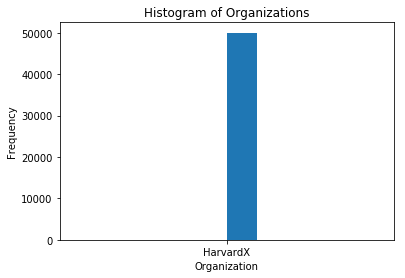

In [79]:
plt.hist(course_school_l)
plt.xlabel('Organization')
plt.ylabel('Frequency')
plt.title("Histogram of Organizations")
plt.show()

Clearly this dataset is biased. It only contains samples of HarvardX students. This seems like something that would be worth flagging to researchers. They should know that this dataset only contains HarvardX classes. We can go a step further and examine what HarvardX classes people are taking.

In [80]:
course_class_l = list(df_drop['course_id'].map(lambda s: s.split('/')[1]))

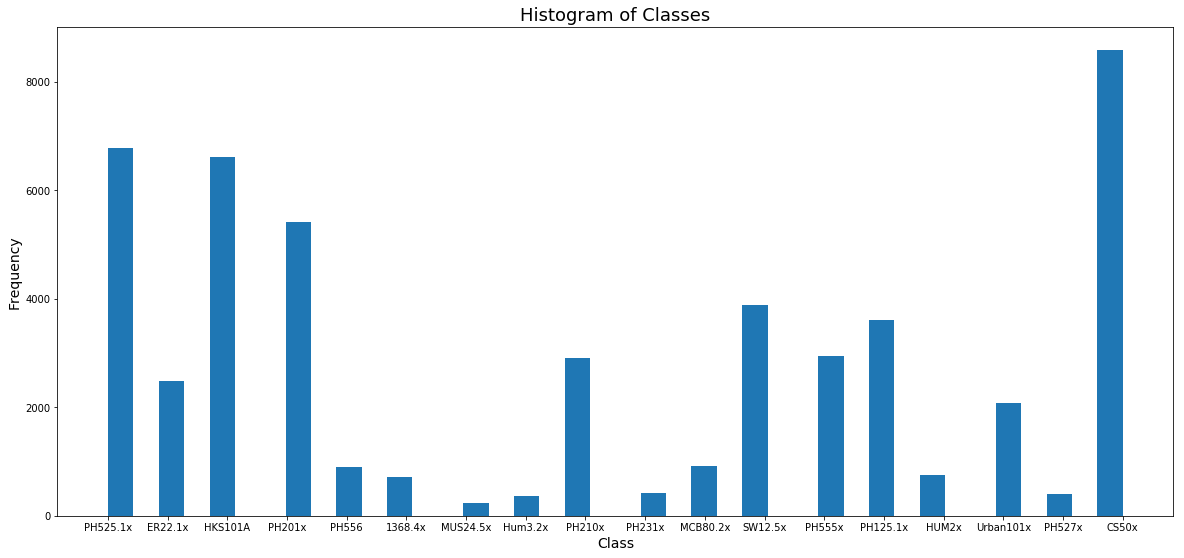

In [95]:
plt.figure(figsize=(20,9))
plt.hist(course_class_l, bins=40, align='mid')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title("Histogram of Classes",fontsize=18)
plt.show()

We see that there is not an even distribution of classes. It is most heavily weighted toward CS50x (surprise surprise). I would say that this distribution is insightful for researchers. Perhaps because this is only a HarvardX dataset and HarvardX's most popular class is CS50x (and CS50 at the University), this could be seen as a source of bias. It is valuable for researchers to know the distributions on these features as it aids them in properly analyzing the data. It is also nice to see that there are no missing classes.

In [180]:
nview = len(df_drop[df_drop['viewed']==True])
nex = len(df_drop[df_drop['explored']==True])
ncomp = len(df_drop[df_drop['completed']==True])
status_l = ['viewed']*nview + ['explored']*nex + ['completed']*ncomp

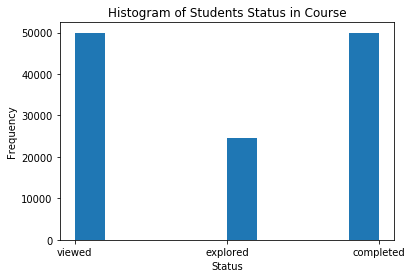

In [181]:
plt.hist(status_l)
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title("Histogram of Students Status in Course")
plt.show()

Completed and viewed are similar. Explored could be lower due to missingness. This is worth noting for researchers.

In [96]:
continent_l = list(df_drop['continent'])

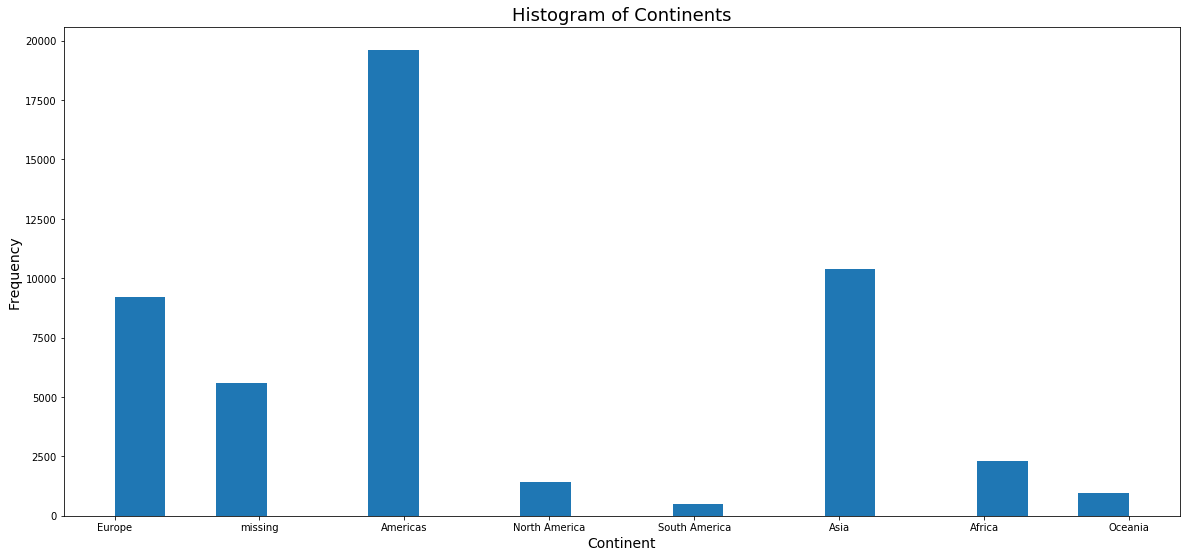

In [104]:
plt.figure(figsize=(20,9))
plt.hist(continent_l, bins=20, align='mid')
plt.xlabel('Continent', fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title("Histogram of Continents",fontsize=18)
plt.show()

The dataset is weighted heavily towards the Americas. There are also the classifications North America and South America which would be classified under Americas. This is something for future researchers to make note of. How should they handle this? Should they reclassify all North America and South America samples with Americas? That could lose information. Ideally they could use `countryLabel` and make a lookup table to derive the continent. That would be the most thorough solution. We leave researchers to decide on what is best for there needs. It is worth noting that we get some missingness in this field, but we are happy that it is not too much of the data.

We shall now explore year of birth, gender, and level of education.

In [117]:
yob_l = list(df_drop[df_drop['YoB']!=0]['YoB'])

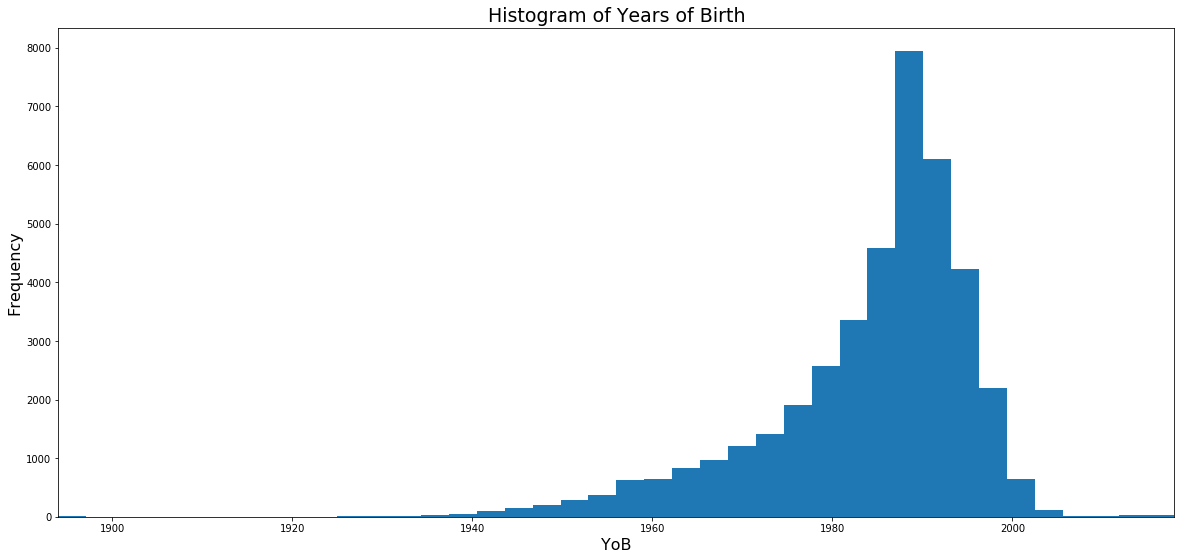

In [132]:
plt.figure(figsize=(20,9))
plt.hist(yob_l, bins=40, align='mid')
plt.xlim(min(yob_l),max(yob_l))
plt.xlabel('YoB', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title("Histogram of Years of Birth",fontsize=19)
plt.show()

In [126]:
print("min year of birth: "+str(min(yob_l)))
print("max year of birth: "+str(max(yob_l)))

min year of birth: 1894
max year of birth: 2018


We have just discovered some peculiar values in our dataset. It is extremely unlikely that someone born in 1894 or 2018 is using the edX. The person born in 1894 would be over 100 years old. The person born in 2018 would be an infant. Could these values be a sign of corruption? Arguably yes, but not in the way that we discussed corruption earlier. It is true that these could be seen as "bad" values. But I personally would not categorize it under corruption. I do think that this would be worth flagging for researchers to handle. I do not think they should be flagged as missing - there is something deliberate in the act of making your birth year one of these ridiculous values. People want to maintain their privacy, and disguising personally identifying data is one of those methods. Perhaps we could add a flag indicating that the year of birth is outside the acceptable range. Or perhaps just a general flag `disguise` to indicate rows that contain out of the ordinary, non-informational values. This would allow researchers to investigate these rows carefully and decide how to handle them. We leave this as an open issue for future research.

In [133]:
gender_l = list(df_drop['gender'])

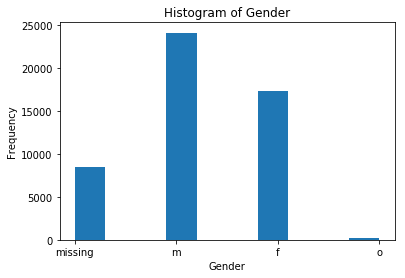

In [134]:
plt.hist(gender_l)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title("Histogram of Gender")
plt.show()

In [136]:
print("Frequency of Other Gender: "+str(len(list(df_drop[df_drop['gender']=='o']))))

Frequency of Other Gender: 77


It is worth noting that the dataset is more weighted towards men. This makes the assumption that the missing values are also similarly or equally distributed between the genders (if missing was all female, the dataset would be more evenly distributed). This is a possible bias for researchers to consider. There are also very few samples with gender classified as other (orders of magnitude less). This could also be a possible bias for researchers to investigage.

In [137]:
loe_l = list(df_drop['LoE'])

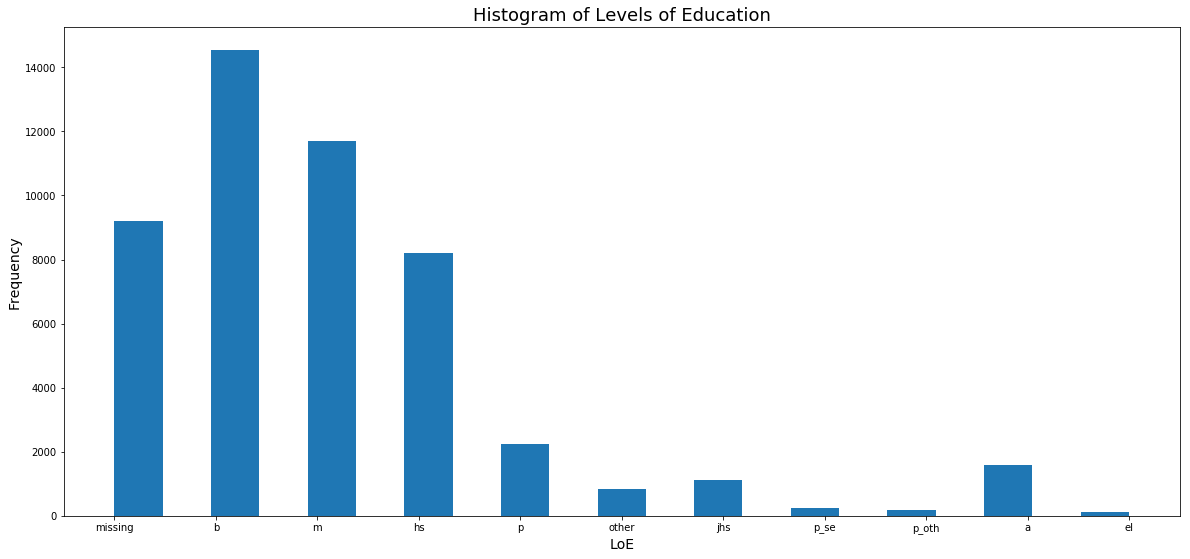

In [144]:
plt.figure(figsize=(20,9))
plt.hist(loe_l, bins=21, align='mid')
plt.xlabel('LoE', fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title("Histogram of Levels of Education",fontsize=18)
plt.show()

There is a skew towards "b" indicating a bachelors. This makes sense as most people (that I would imagine seeking additional education online) have gone to college for their bachelors. Masters and high school are also quite high. I would have expected high school to be higher than masters as I expect many prudent high school kids seek additional education to prepare for college.

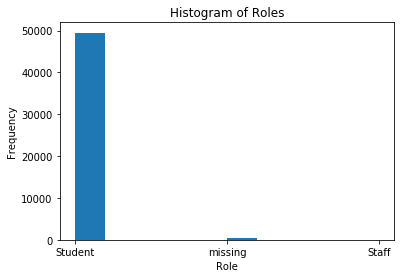

In [146]:
plt.hist(list(df_drop['roles']))
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.title("Histogram of Roles")
plt.show()

In [147]:
print("Number of staff: "+str(len(df_drop[df_drop['roles']=='Staff'])))

Number of staff: 59


The dataset is highly biased towards students. This makes sense as staff are often out numbered by students in classes - even more so in an online class. This is worth making note of when researchers first analyze the dataset, though they wont find this surprising.

Finally, we shall examine distributions on `grade` and `passing_grade`.

In [158]:
grade_l = list(df_drop[df_drop['missing_grade']==False]['grade'])

By only using rows that had the grade, we avoid the problem of 0s overwhelming the dataset due to the default missing value for grade being 0. This will prove helpful when looking at `passing_grade` as well.

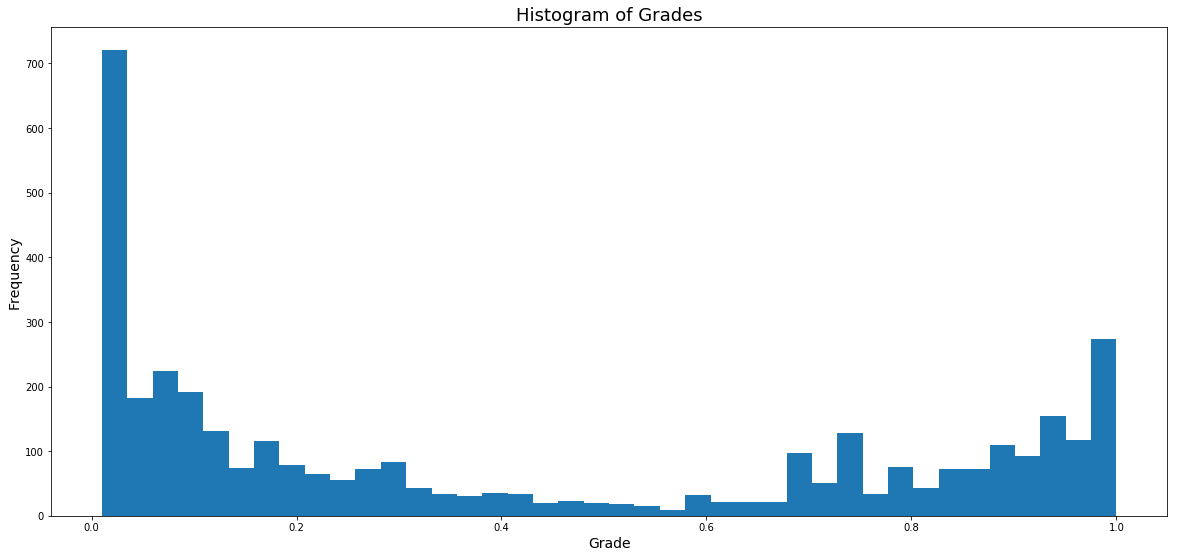

In [161]:
plt.figure(figsize=(20,9))
plt.hist(grade_l, bins=40, align='mid')
plt.xlabel('Grade', fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title("Histogram of Grades",fontsize=18)
plt.show()

In [168]:
print("minimum grade: "+str(min(grade_l)))
print("average grade: "+str(round(np.mean(grade_l),2)))

minimum grade: 0.01
average grade: 0.41


It is interesting to note that the minimum grade (for non missing grade values) was above 0. Therefore no one can actually finish a course with a grade of 0. This could be worth noting to researchers. The grades are distributed towards the ends of the ranges, therefore more people complete the course with decent grades and more people fail with bad grades than people that get the average grade (0.41).

In [163]:
passing_grade_l = list(df_drop[df_drop['missing_passing_grade']==False]['passing_grade'])

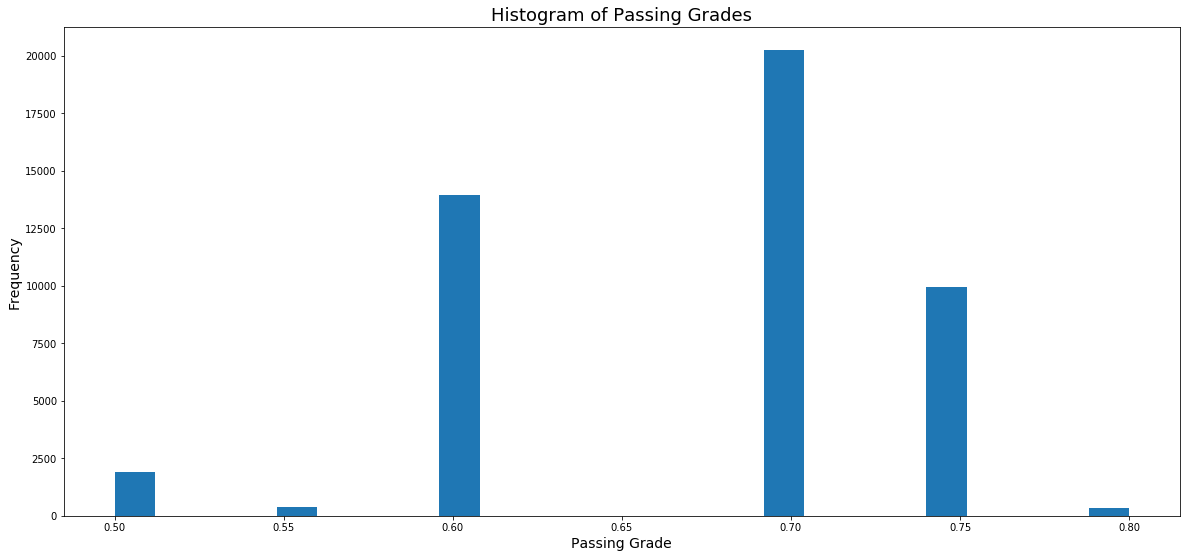

In [175]:
plt.figure(figsize=(20,9))
plt.hist(passing_grade_l, bins=25, align='mid')
plt.xlabel('Passing Grade', fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title("Histogram of Passing Grades",fontsize=18)
plt.show()

Passing grades fall on regular intervals, which is expected.

We have finished analyzing bias and fully cleaned the dataset.

## Exporting Clean Dataset

Now that we have finished analyzing and cleaning the dataset, we write it to a file for future researchers to use.

In [182]:
df_drop.to_csv("../clean_sample_small.csv")

And we are finished!